 Keras에서 GAN 모델을 생성하는 것은 Tensorflow와 다르다. Supervised Learning 목적이기 때문에, 직접 loss 함수를 만들어 학습하기가 어렵다. 따라서 지도 학습 방식으로 바꾸어 GAN 네트워크를 학습한다.

In [1]:
# module import
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# eager execution 기능 끄기
tf.compat.v1.disable_eager_execution()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# _1_. 데이터 생성 

In [2]:
# 정규분포 데이터 샘플링
real_data = np.random.normal(size=1000)
real_data = real_data.reshape(real_data.shape[0], 1)

In [3]:
# 파라미터 설정
d_input = real_data.shape[1]
d_hidden = 32
d_output = 1 # 주의
g_input = 16
g_hidden = 32
g_output = d_input

# _2_. 필요한 함수 만들기

In [4]:
def calc_KL(P, Q):
    
    hist_P, bins_P = np.histogram(P, bins=100)
    hist_Q, bins_Q = np.histogram(Q, bins=bins_P)

    # pdf로 만들기 위해 정규화
    hist_P = hist_P / (np.sum(hist_P) + 1e-8) # 분모 0 방지
    hist_Q = hist_Q / (np.sum(hist_Q) + 1e-8) 

    # KL divergence 계산
    kld = np.sum(hist_P * (np.log(hist_P + 1e-8) - np.log(hist_Q + 1e-8)))

    return kld

In [5]:
def getNoise(m, n=g_input):
    z = np.random.uniform(-1.0, 1.0, size=[m, n])
    return z

In [6]:
def myOptimizer(a):
    return RMSprop(learning_rate=a)

# _2_. Discriminator
- label을 붙일 (나중의) Input과 그것이 진짜인지(1) 가짜인지(0) 판단해서 sigmoid로 출력해 주는 Output이 있다.
- Input, Output의 모델을 생성한다.
- discriminator는 학습한다.

In [9]:
def build_discriminator():
    d_x = Input(batch_shape=(None, d_input))
    d_h = Dense(d_hidden, activation='relu')(d_x)
    d_o = Dense(d_output, activation='sigmoid')(d_h)
    
    d_model = Model(d_x, d_o)
    d_model.compile(loss='binary_crossentropy', optimizer=myOptimizer(0.001))
    
    return d_model

# _3_. Generator
* 가짜 데이터를 생성한다.
* 모델을 만들기는 하나, 학습은 하지 않는다. 따라서 compile하지 않는다.
* 출력 시 활성화는 그대로 출력하도록 하는 linear이다.

In [10]:
def build_generator():
    g_x = Input(batch_shape=(None, g_input))
    g_h = Dense(g_hidden, activation='relu')(g_x)
    g_o = Dense(g_output, activation='linear')(g_h)

    g_model = Model(g_x, g_o)
    
    return g_model

# _4_. GAN 네트워크

```
        +---+   Gz   +---+
  z --->| G |------->| D |---> DGz
        +---+        +---+
      trainable   not trainable
```

* 기본적으로 z가 들어가면, DGz가 1이 나오도록 G가 학습된다.
* 이 때 D는 위에서 학습하므로, G의 네트워크만 업데이트한다.
* G는 여기서 학습된다. 컴파일을 여기서!
    - 이진 분류 지도 학습 문제로 바꾸어 풀기 때문에, loss는 `binary_crossentropy`.
    

In [11]:
def build_GAN(discriminator, generator):
    discriminator.trainable = False # discriminator 업데이트 해제
    z = Input(batch_shape=(None, g_input))
    Gz = generator(z)
    DGz = discriminator(Gz)

    gan_model = Model(z, DGz)
    gan_model.compile(loss='binary_crossentropy', optimizer = myOptimizer(0.0005))

    return gan_model

# _5_. 학습
- 그래프 초기화 왜 있죠?
- PyTorch에서 마지막이면 끝 데이터까지 쓰는 거 훨씬 쉽게 사용할 수 있을 듯!
- G(generator) 자체를 모델로 만들었기 때문에, `model.predict` 해야 노이즈 데이터 생성할 수 있음.
- `.fit`보다 `.train_on_batch`
- 학습 방식: D 1회, G 1회 --> 이렇게 한 번 돌아야 에폭 1회.
- generator : GAN 네트워크 자체에서 학습됨.

---

- ? `*2` 왜? batch 안에 들어 있는 개수만큼 generate했으므로!
- generator는 `X_Batch.shape[0]`만 해준다? 제너레이터는 만들어 내는 것에 대해서만 학습??
- `g_target[:]`으로 해야 바뀜!


In [15]:
# 그래프 초기화
K.clear_session()
D = build_discriminator()
G = build_generator()
GAN = build_GAN(D, G)

n_batch_cnt = int(input('입력 데이터 배치 블록 수 설정: '))
n_batch_size = int(real_data.shape[0] / n_batch_cnt) # 배치 블록 당 사이즈
EPOCHS = int(input('학습 횟수 설정: '))

for epoch in range(EPOCHS):

    # 미니배치 학습
    for n in range(n_batch_cnt):
        from_, to_ = n*n_batch_size, (n+1)*n_batch_size

        # 마지막 루프라면 n_to는 끝까지
        if n == n_batch_cnt - 1:
            to_ = real_data.shape[0]
        
        # 학습 데이터 배치로 준비
        X_batch = real_data[from_ : to_]
        Z_batch = getNoise(m = X_batch.shape[0], n = g_input)
        Gz = G.predict(Z_batch) # predict 해야 제너레이터가 만들어낼 수 있음.

        # discriminator 학습을 위한 데이터 준비
        d_target = np.zeros(X_batch.shape[0] * 2) # batch 안에 들어 있는 개수만큼 generate
        d_target[:X_batch.shape[0]] = 0.9 # 1.0 대신 0.9
        d_target[X_batch.shape[0]:] = 0.1 # 0.0 대신 0.1

        # discriminator 학습
        X_batch_Gz = np.concatenate([X_batch, Gz])
        loss_discriminator = D.train_on_batch(X_batch_Gz, d_target)

        # generator 학습
        g_target = np.zeros(X_batch.shape[0])
        g_target[:] = 0.9
        loss_generator = GAN.train_on_batch(Z_batch, g_target)

    if epoch % 10 == 0:
        z = getNoise(m = real_data.shape[0], n=g_input)
        fake_data = G.predict(z) # generator 모델이 가짜 분포 생성
        kld = calc_KL(real_data, fake_data) # KL Divergence 계산
        print(f"epoch: %d, D-Loss = %.4f, G-Loss = %.4f, KL-divergence = %.4f" % (epoch, loss_discriminator, loss_generator, kld))

입력 데이터 배치 블록 수 설정: 3
학습 횟수 설정: 1000
epoch: 0, D-Loss = 0.6802, G-Loss = 0.6699, KL-divergence = 2.3204
epoch: 10, D-Loss = 0.6760, G-Loss = 0.6766, KL-divergence = 1.5530
epoch: 20, D-Loss = 0.6843, G-Loss = 0.6920, KL-divergence = 0.5916
epoch: 30, D-Loss = 0.6963, G-Loss = 0.7011, KL-divergence = 0.2417
epoch: 40, D-Loss = 0.6969, G-Loss = 0.7040, KL-divergence = 0.1622
epoch: 50, D-Loss = 0.6950, G-Loss = 0.7172, KL-divergence = 0.1795
epoch: 60, D-Loss = 0.6925, G-Loss = 0.7197, KL-divergence = 0.1829
epoch: 70, D-Loss = 0.6935, G-Loss = 0.6937, KL-divergence = 0.2673
epoch: 80, D-Loss = 0.6927, G-Loss = 0.6964, KL-divergence = 0.3166
epoch: 90, D-Loss = 0.6932, G-Loss = 0.6937, KL-divergence = 0.1891
epoch: 100, D-Loss = 0.6929, G-Loss = 0.6929, KL-divergence = 0.1398
epoch: 110, D-Loss = 0.6930, G-Loss = 0.6949, KL-divergence = 0.2168
epoch: 120, D-Loss = 0.6932, G-Loss = 0.6948, KL-divergence = 0.1970
epoch: 130, D-Loss = 0.6930, G-Loss = 0.6942, KL-divergence = 0.1402
epoch: 14

# _6_. 데이터 분포 그려 보기
* 역시나, 여기서도 model이기 때문에 predict해야 분포가 나온다.

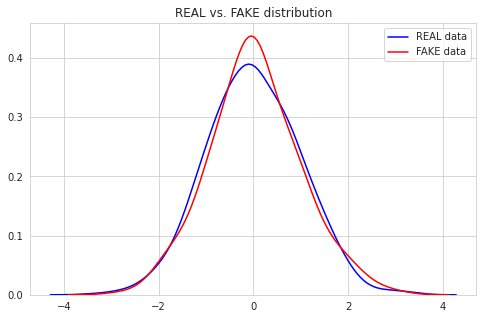

In [16]:
# 데이터 분포
z = getNoise(m = real_data.shape[0], n=g_input)
fake_data = G.predict(z) # predict해야 data 나옴.

plt.figure(figsize=(8, 5))
sns.set_style('whitegrid')
sns.kdeplot(real_data[:, 0], color='blue', bw=0.3, label='REAL data')
sns.kdeplot(fake_data[:, 0], color='red', bw=0.3, label='FAKE data')
plt.legend()
plt.title('REAL vs. FAKE distribution')
plt.show()

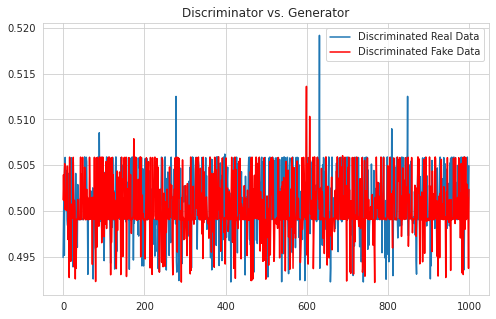

In [20]:
# 실제 데이터 넣어서 discriminator가 어떻게 예측하는지 보기
discriminate_real_values = D.predict(real_data)
discriminate_fake_values = D.predict(fake_data)

plt.figure(figsize=(8, 5))
plt.plot(discriminate_real_values, label='Discriminated Real Data')
plt.plot(discriminate_fake_values, label='Discriminated Fake Data', color='red')
plt.title("Discriminator vs. Generator")
plt.legend()
plt.show()

# 해석
- GAN 모델 구조를 확인하면, layer가 아니라 model이 들어 있다.
- model이 통째로 안에 들어 있는 것이라고 해석한다.

In [23]:
# GAN model 구조 확인
print(GAN.summary())
print(G.summary())
print(D.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
model_1 (Model)              (None, 1)                 577       
_________________________________________________________________
model (Model)                (None, 1)                 97        
Total params: 674
Trainable params: 577
Non-trainable params: 97
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
______________________________________